<a href="https://colab.research.google.com/github/2walkingfish/Neuromatch_Project_133/blob/master/Explore_steinmetz_extra_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [44]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN

from sklearn.manifold import TSNE

In [2]:
#@title Data retrieval
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [4]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
#@title Data loading
import numpy as np

dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']


# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = dat_LFP[11]
print(dat.keys())
dat = dat_WAV[11]
print(dat.keys())
dat = dat_ST[11]
print(dat.keys())

dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp'])
dict_keys(['waveform_w', 'waveform_u', 'trough_to_peak'])
dict_keys(['ss', 'ss_passive'])


`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files. 

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial. 
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [6]:
print(dat_LFP[1]['lfp'].shape)
print(dat_LFP[1]['lfp_passive'].shape)
print(dat_LFP[1]['brain_area_lfp'])


(4, 251, 250)
(4, 150, 250)
['CA1', 'VISl', 'POST', 'VISpm']


In [ ]:
for i in range(dat_LFP[1]['lfp'].shape[1]):
  plt.plot(dat_LFP[1]['lfp'][3][i])
  plt.show()

In [9]:
print(dat_ST[0]['ss'].shape)
print(dat_ST[0]['ss_passive'].shape)

(734, 214)
(734, 150)


In [21]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [22]:
dat_WAV[0]['waveform_w'][0][0].shape



(3,)

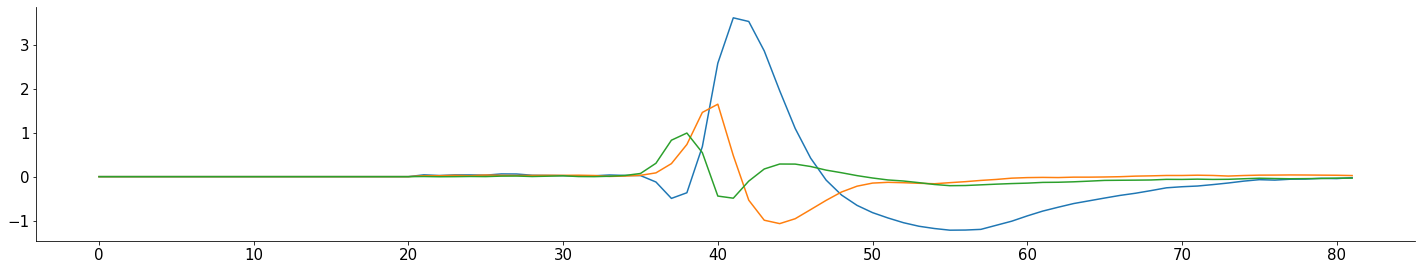

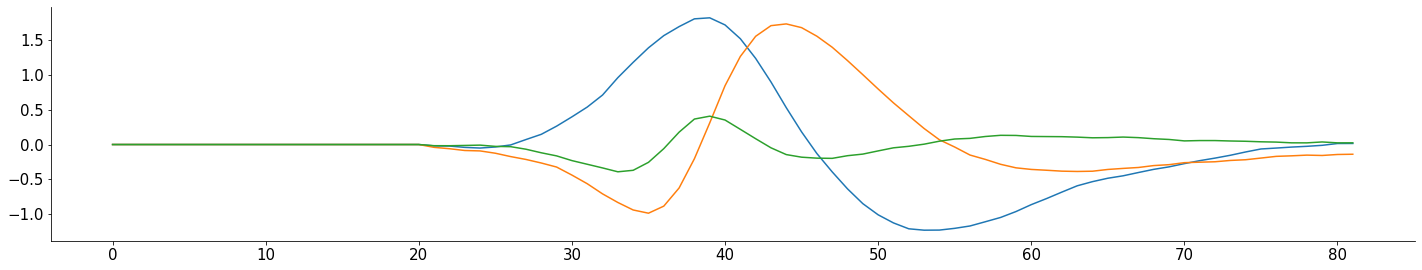

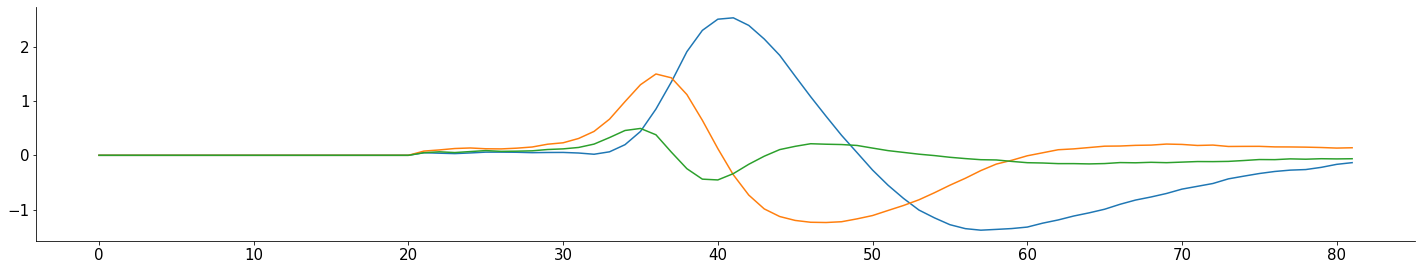

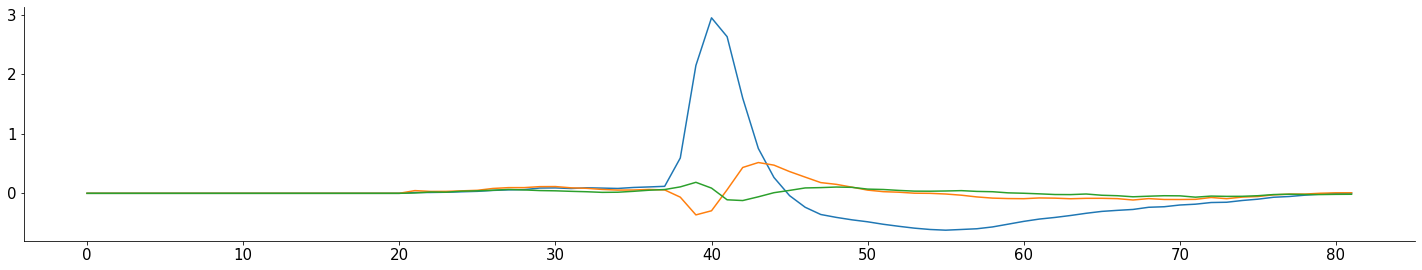

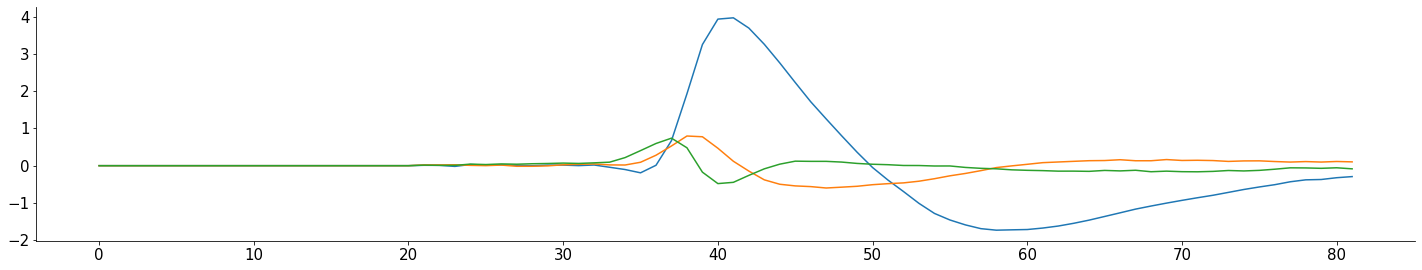

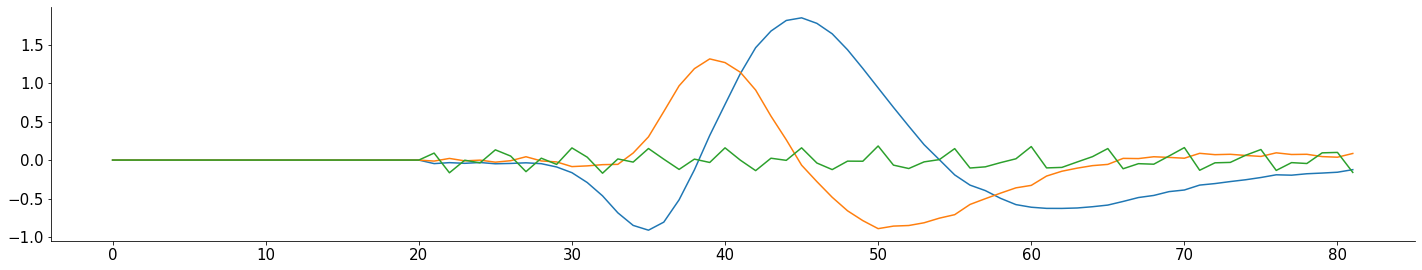

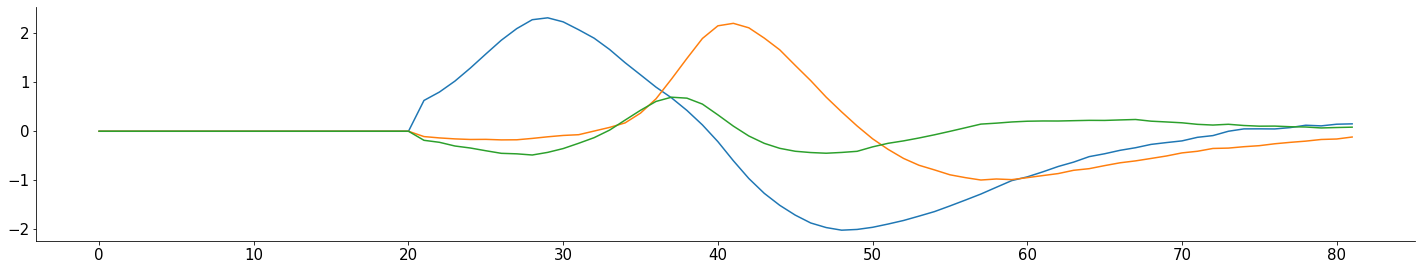

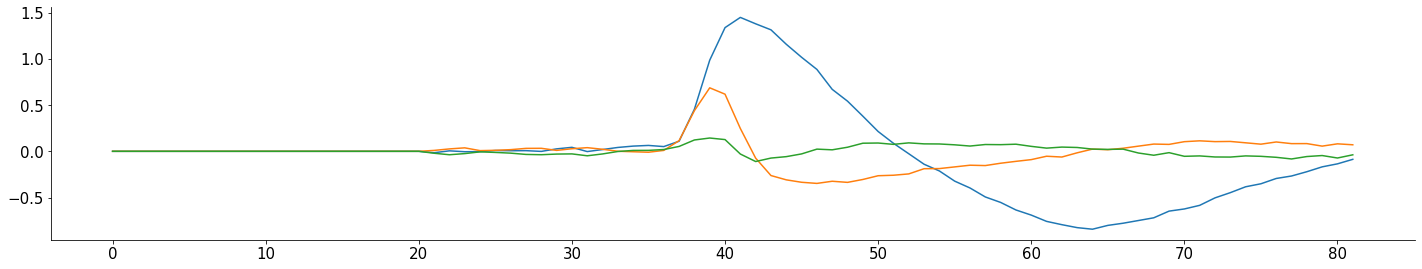

KeyboardInterrupt: ignored

In [23]:
for i in range(0, dat_WAV[38]['waveform_w'].shape[0]):

  plt.plot(dat_WAV[38]['waveform_w'][i])
  plt.show()

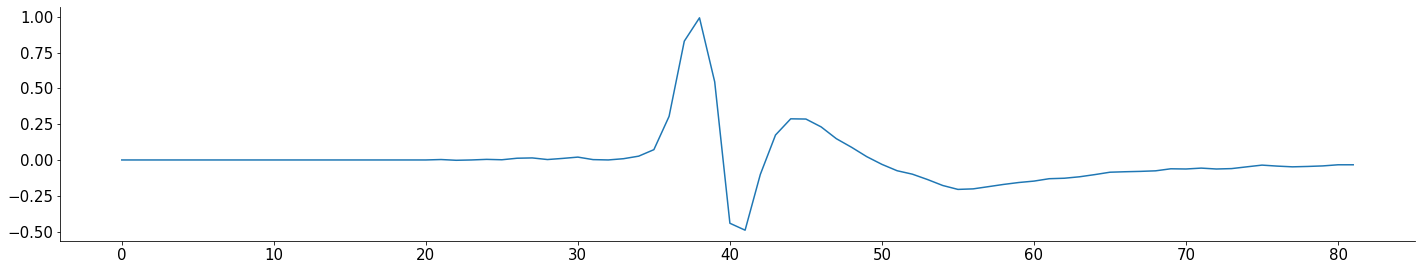

In [18]:
plt.plot(dat_WAV[38]['waveform_w'][0,:,2])

In [21]:
print(dat_WAV[38]['waveform_w'].shape[0])

1348


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
[0.49775857 0.22762728]
singular_values [117.085144  79.17801 ]
explained_variance_ratio_ [0.49775857 0.22762728]


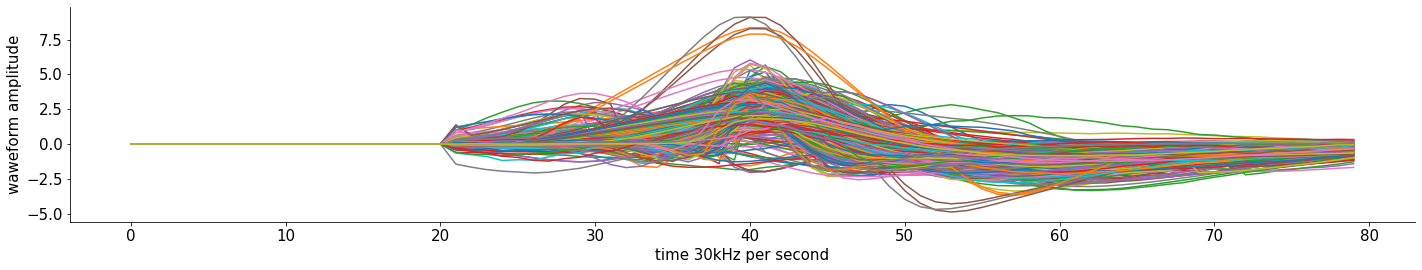

In [38]:
selected_trial = 38 
pca = PCA(n_components = 2)

i_range = range(0, dat_WAV[selected_trial]['waveform_w'].shape[0])

data_stack = np.empty_like(dat_WAV[selected_trial]['waveform_w'][0,0:80,0])
for i in i_range:
  if (dat_WAV[selected_trial]['waveform_w'][i,0:80,0].any()!= np.nan):
    data_stack =np.vstack((data_stack, dat_WAV[selected_trial]['waveform_w'][i,0:80,0]))

result_pca = pca.fit(data_stack)

print(result_pca)

print(pca.explained_variance_ratio_)
print('singular_values', pca.singular_values_)
print('explained_variance_ratio_', pca.explained_variance_ratio_)

plt.plot(data_stack.T)

plt.ylabel('waweform amplitude')
plt.xlabel('time 30kHz per second')


plt.show()




Text(0, 0.5, 'PCA_2')

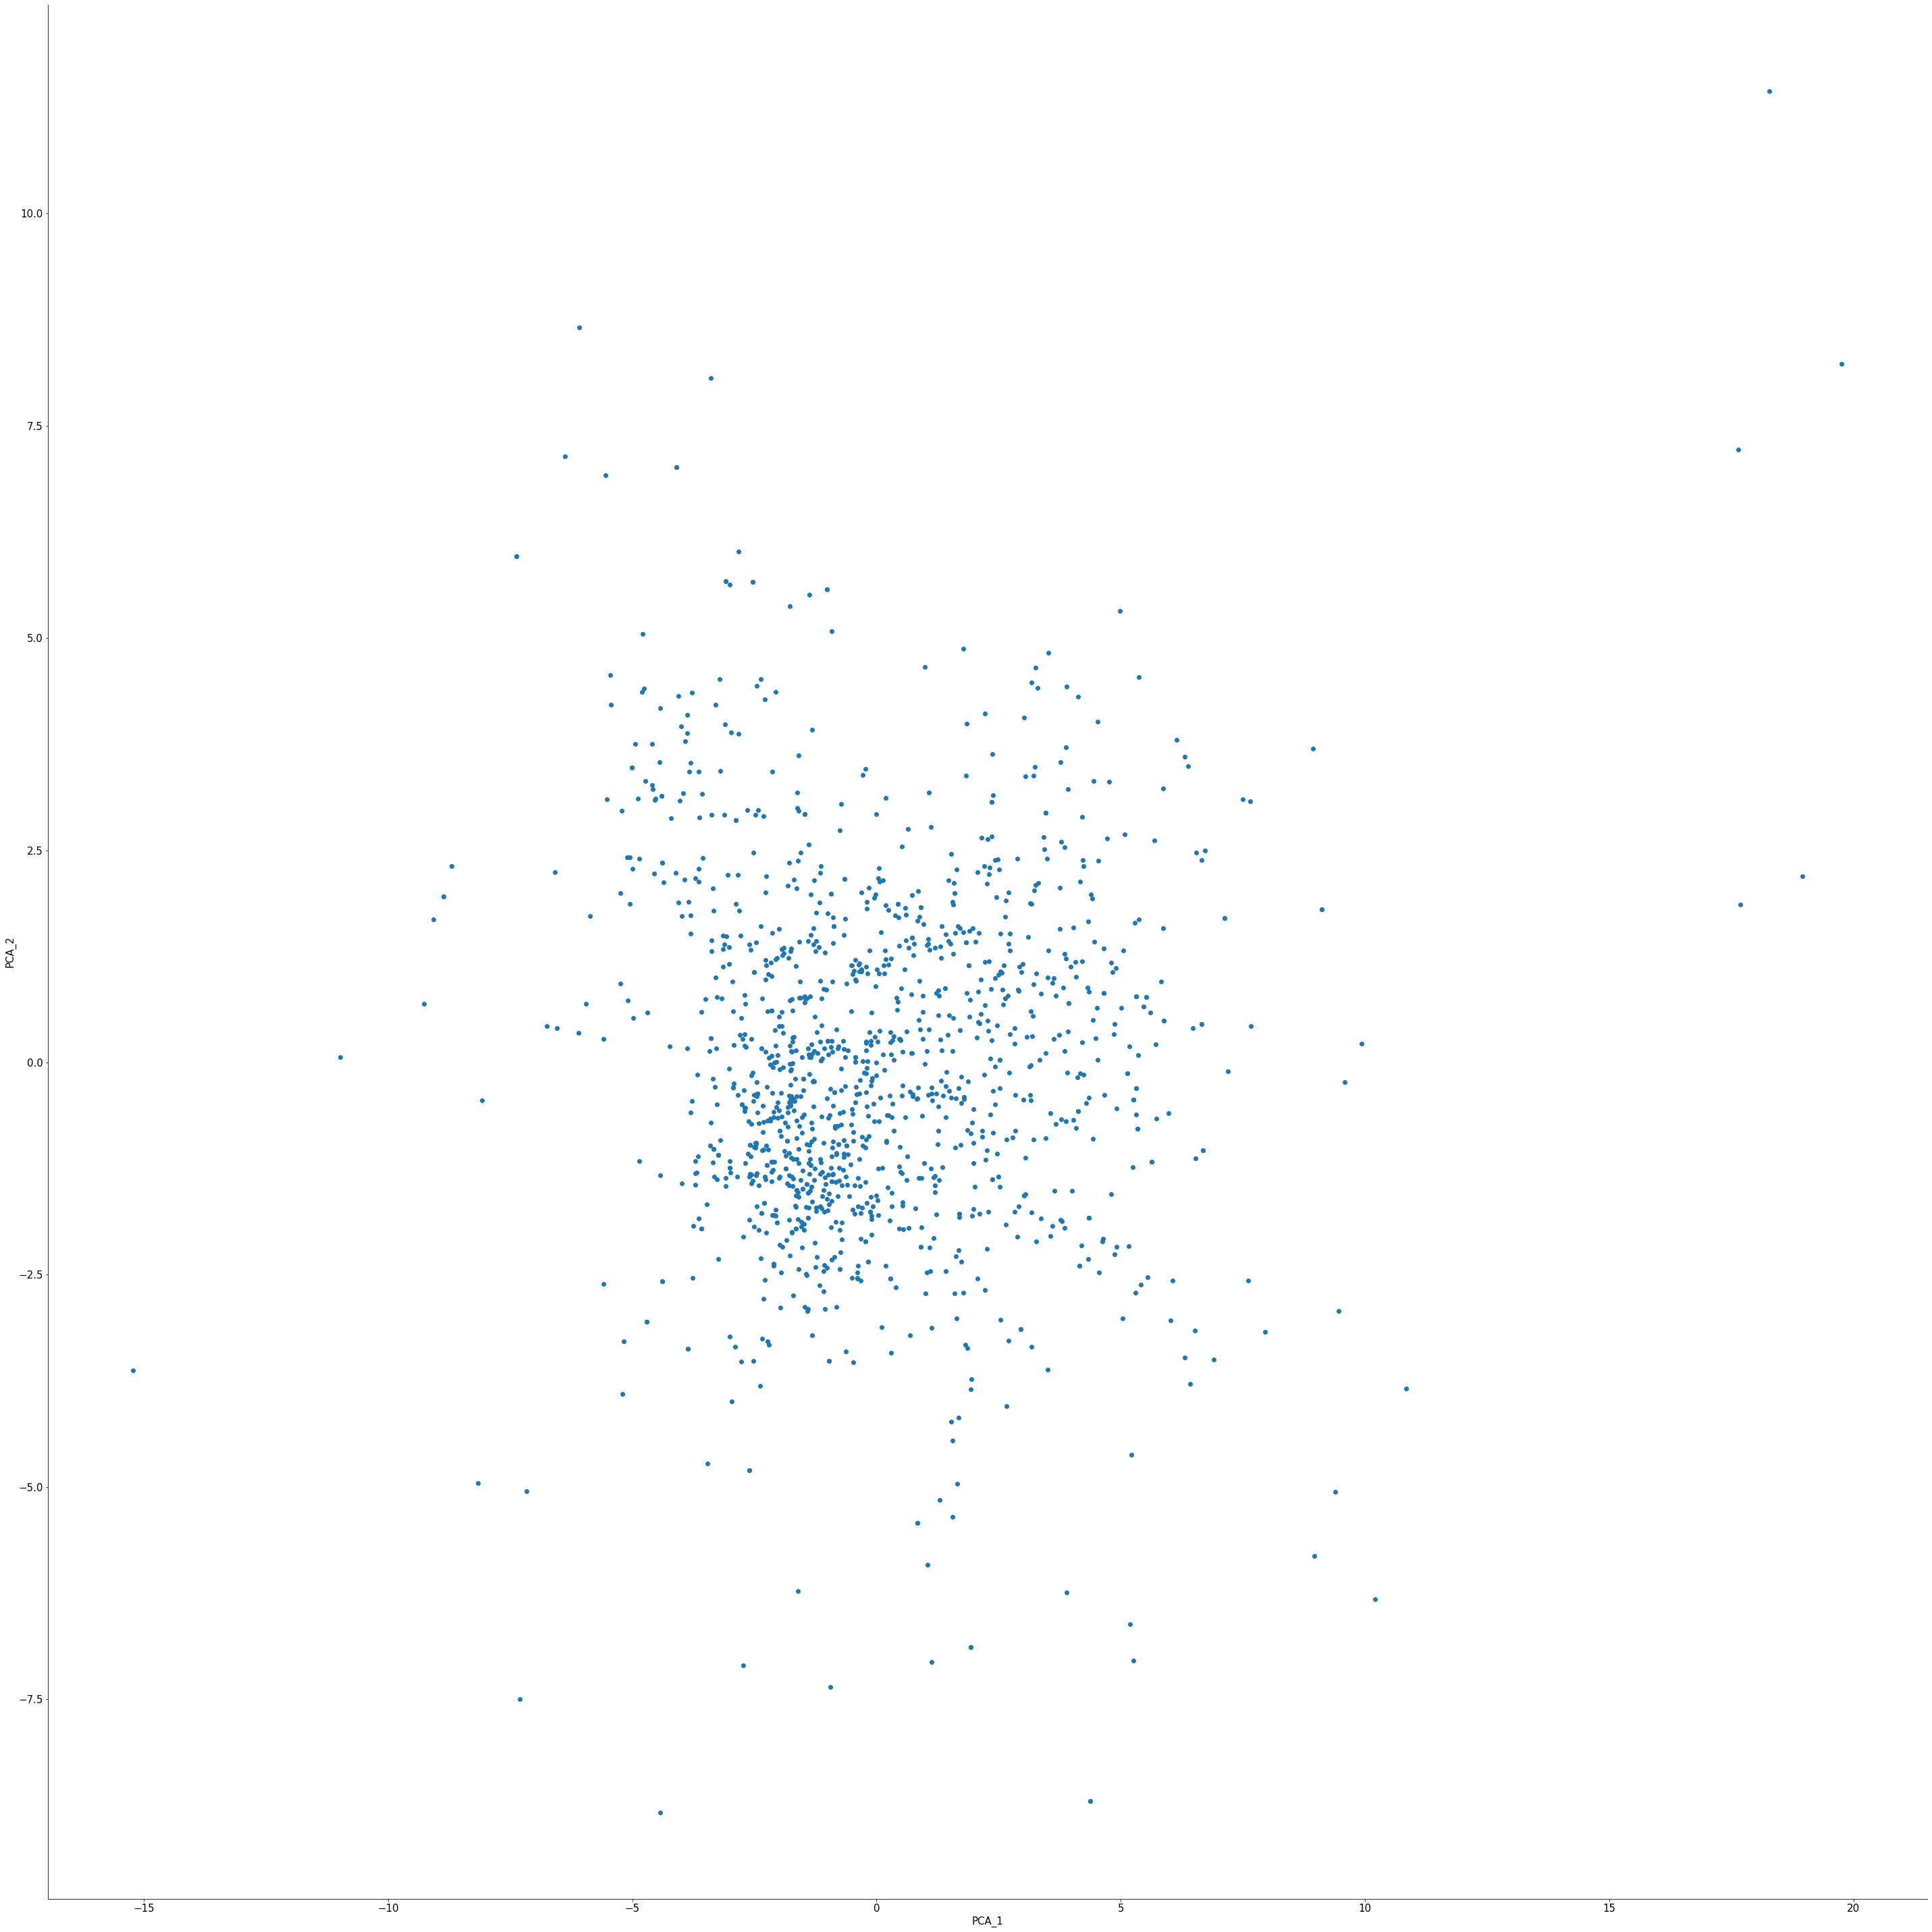

In [40]:
transformation_results = pca.fit_transform(data_stack)
# print(result)

plt.figure(figsize=(40,40))
plt.scatter(transformation_results[:,0],transformation_results[:,1])
# plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('PCA_1')
plt.ylabel('PCA_2')

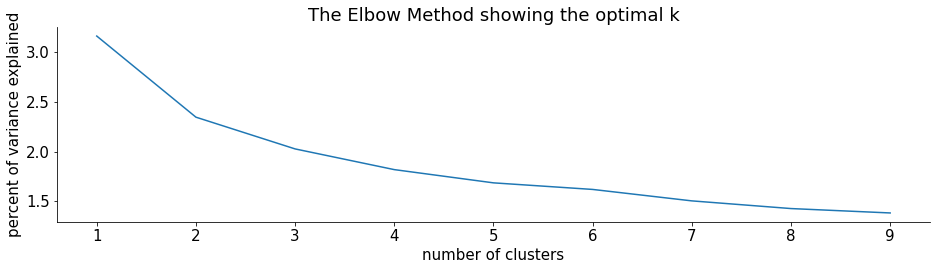

In [66]:
percent_of_var_explained = []

cluster_range = range(1,10)
for cluster_nums in cluster_range:
  kmeans_m = KMeans(n_clusters = cluster_nums,  random_state=0).fit(transformation_results)
  percent_of_var_explained.append(sum(np.min(cdist(transformation_results, kmeans_m.cluster_centers_,'euclidean')
  ,axis = 1))/transformation_results.shape[0])

plt.plot(cluster_range, percent_of_var_explained)
plt.gca().set_aspect('equal')
plt.xlabel('number of clusters')
plt.ylabel('percent of variance explained')
plt.title('The Elbow Method showing the optimal k')
plt.show()


 

Text(0, 0.5, 'PCA_2')

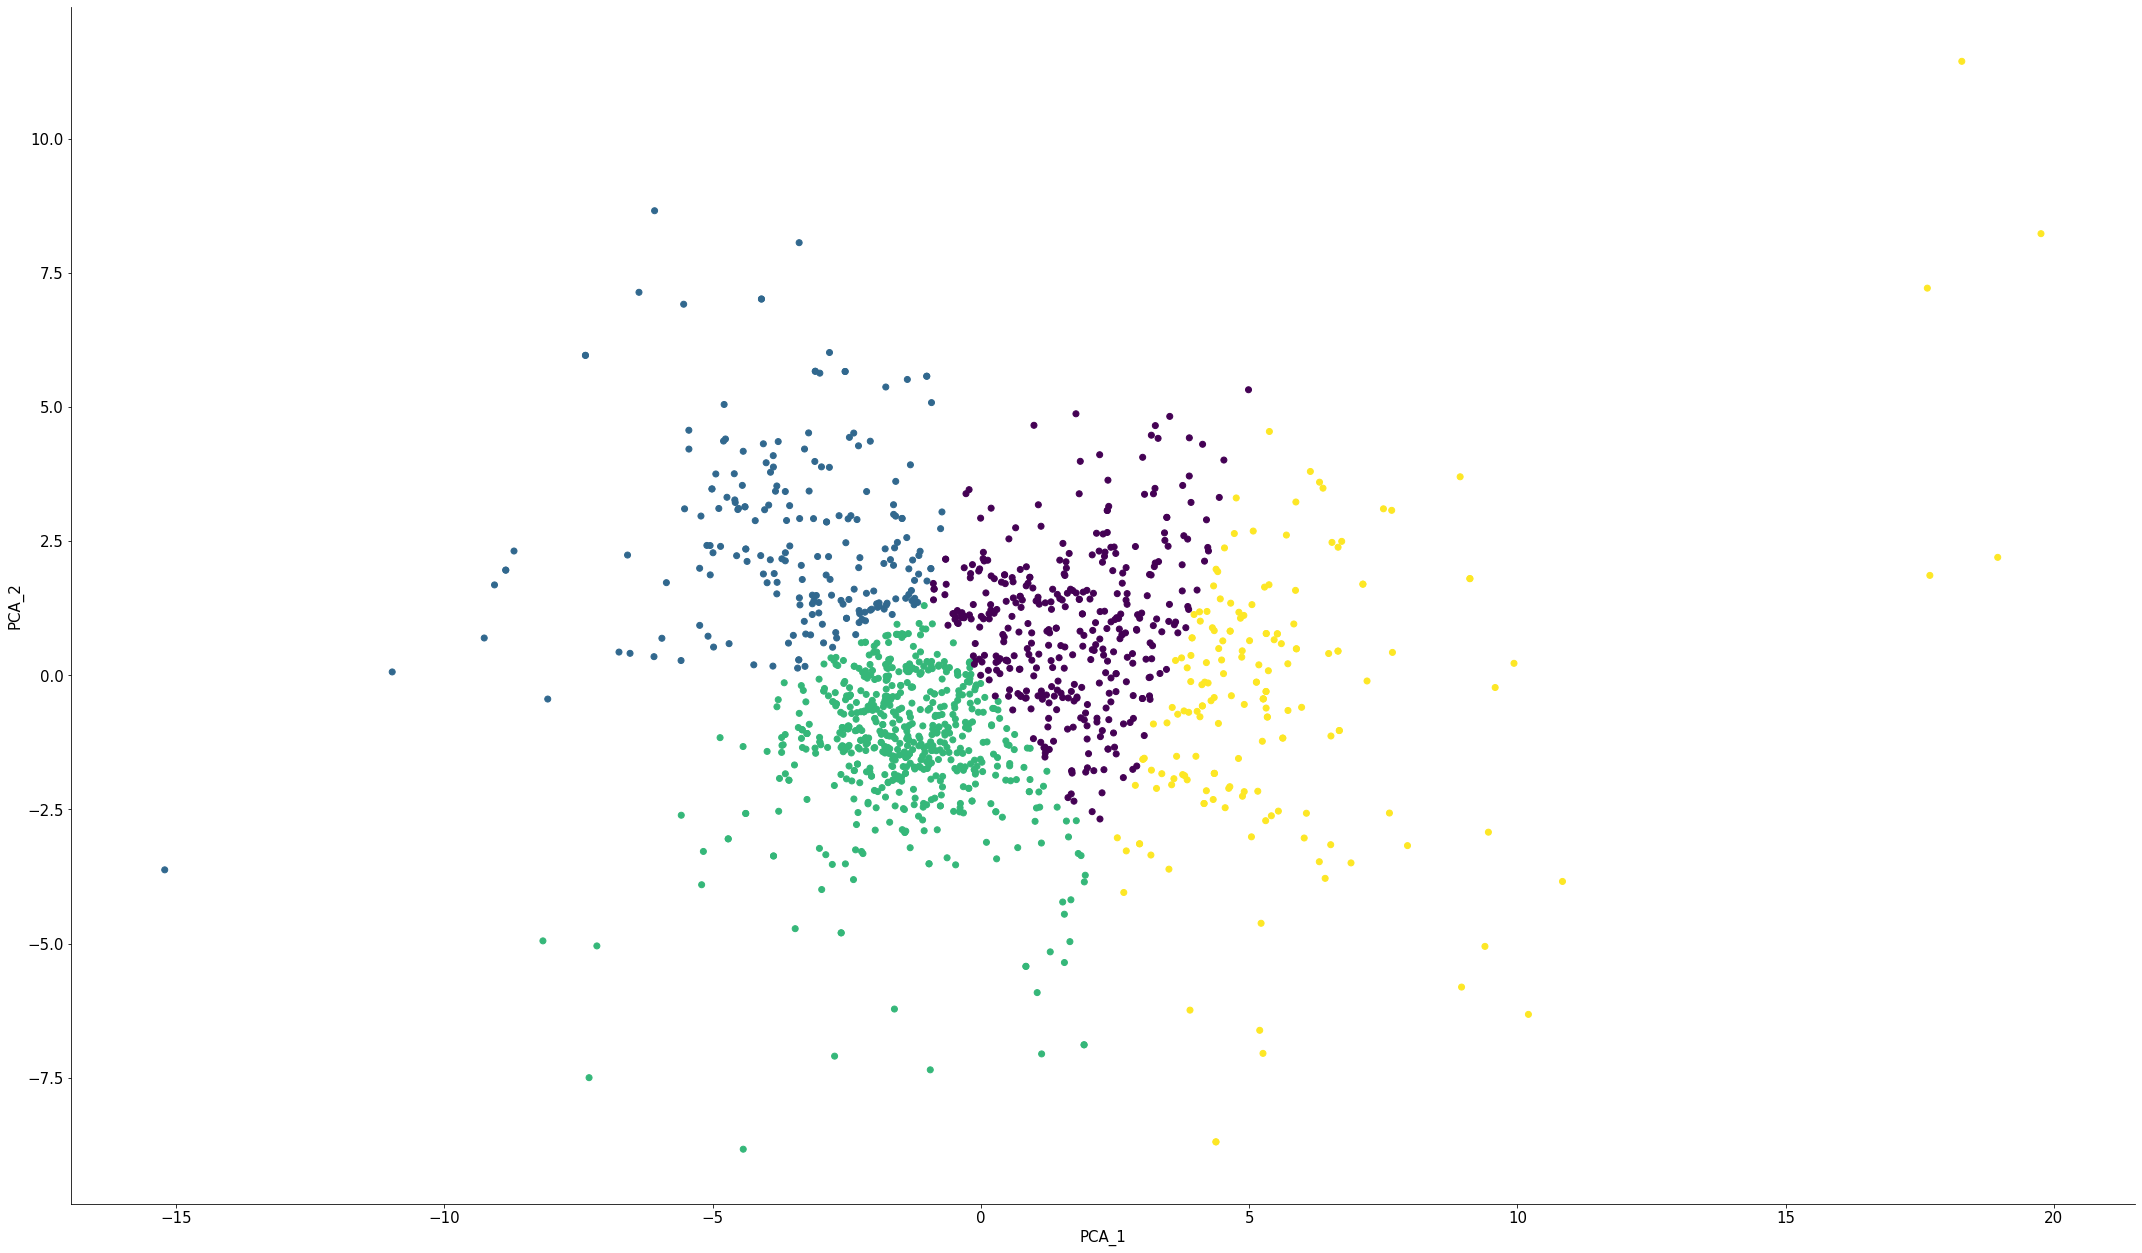

In [106]:
kmeans = KMeans(n_clusters = 4,  random_state=1).fit(transformation_results)
labels_kmeans = kmeans.labels_

plt.figure(figsize=(30,30))
plt.scatter(transformation_results[:,0],transformation_results[:,1], c= labels_kmeans)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('PCA_1')
plt.ylabel('PCA_2')

# 1. optimal number of clusters? 
# 2. cluster with different pca selected; leave out method
# 3. how often unit has the same label? 

number of labels 5


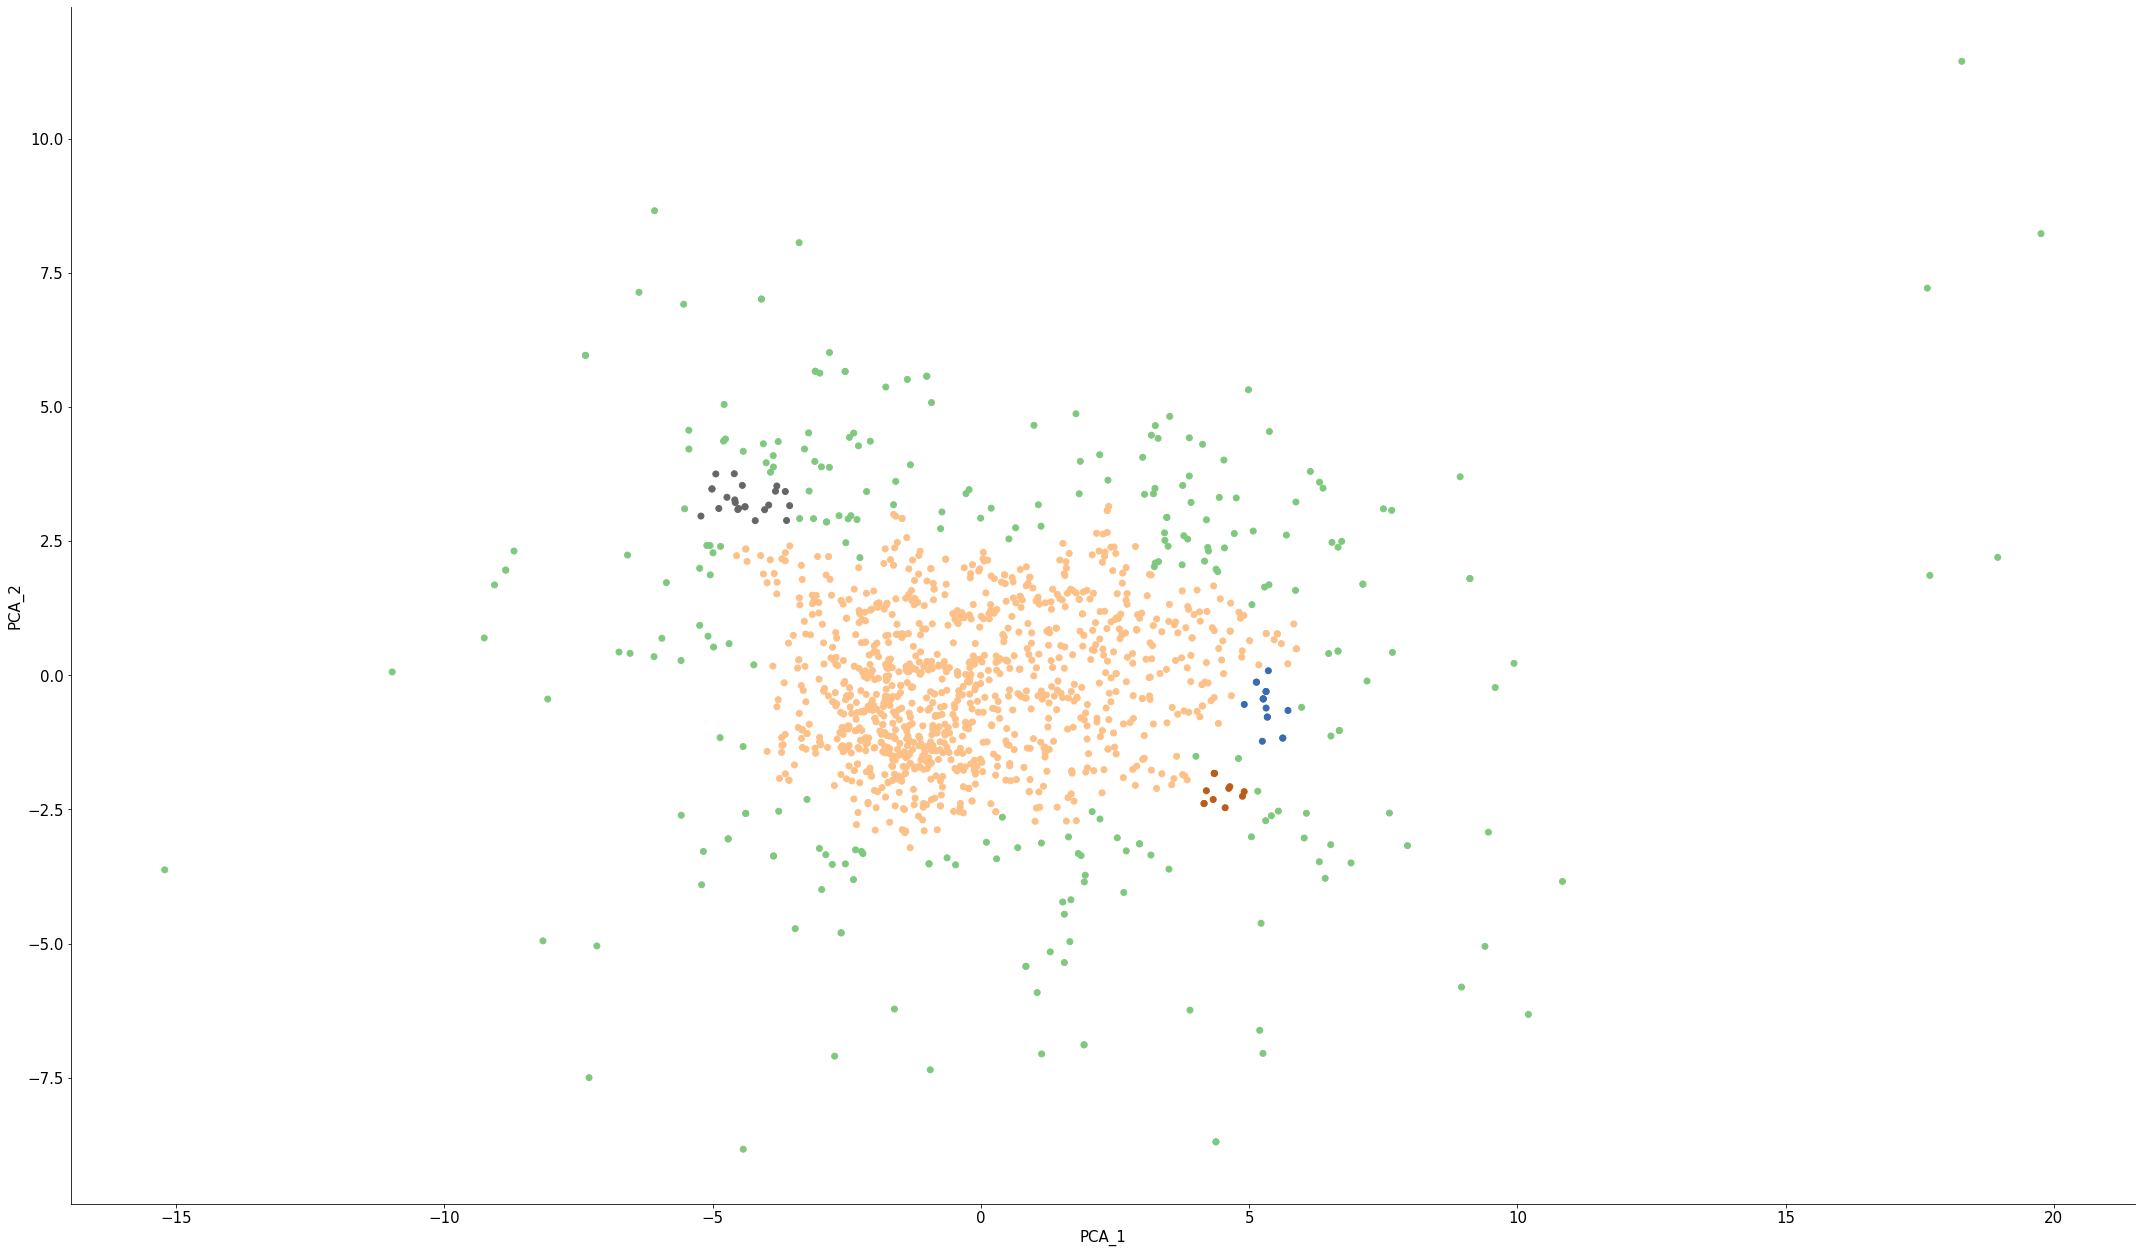

In [43]:
density_clusters = DBSCAN(eps=0.5, min_samples = 10, metric='euclidean').fit(transformation_results)

labels_DBSCAN = density_clusters.labels_

plt.figure(figsize=(30,30))
plt.scatter(transformation_results[:,0],transformation_results[:,1], c= labels_DBSCAN, cmap='Accent')
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('PCA_1')
plt.ylabel('PCA_2')

print('number of labels', len(set(labels_DBSCAN)))


**Apply t-SNE for wawelet component with the highest amplitude**


In [67]:
def visualize_components(component1, component2, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure(figsize=(30,30))
  plt.scatter(x=component1, y=component2)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  if show:
    plt.show()

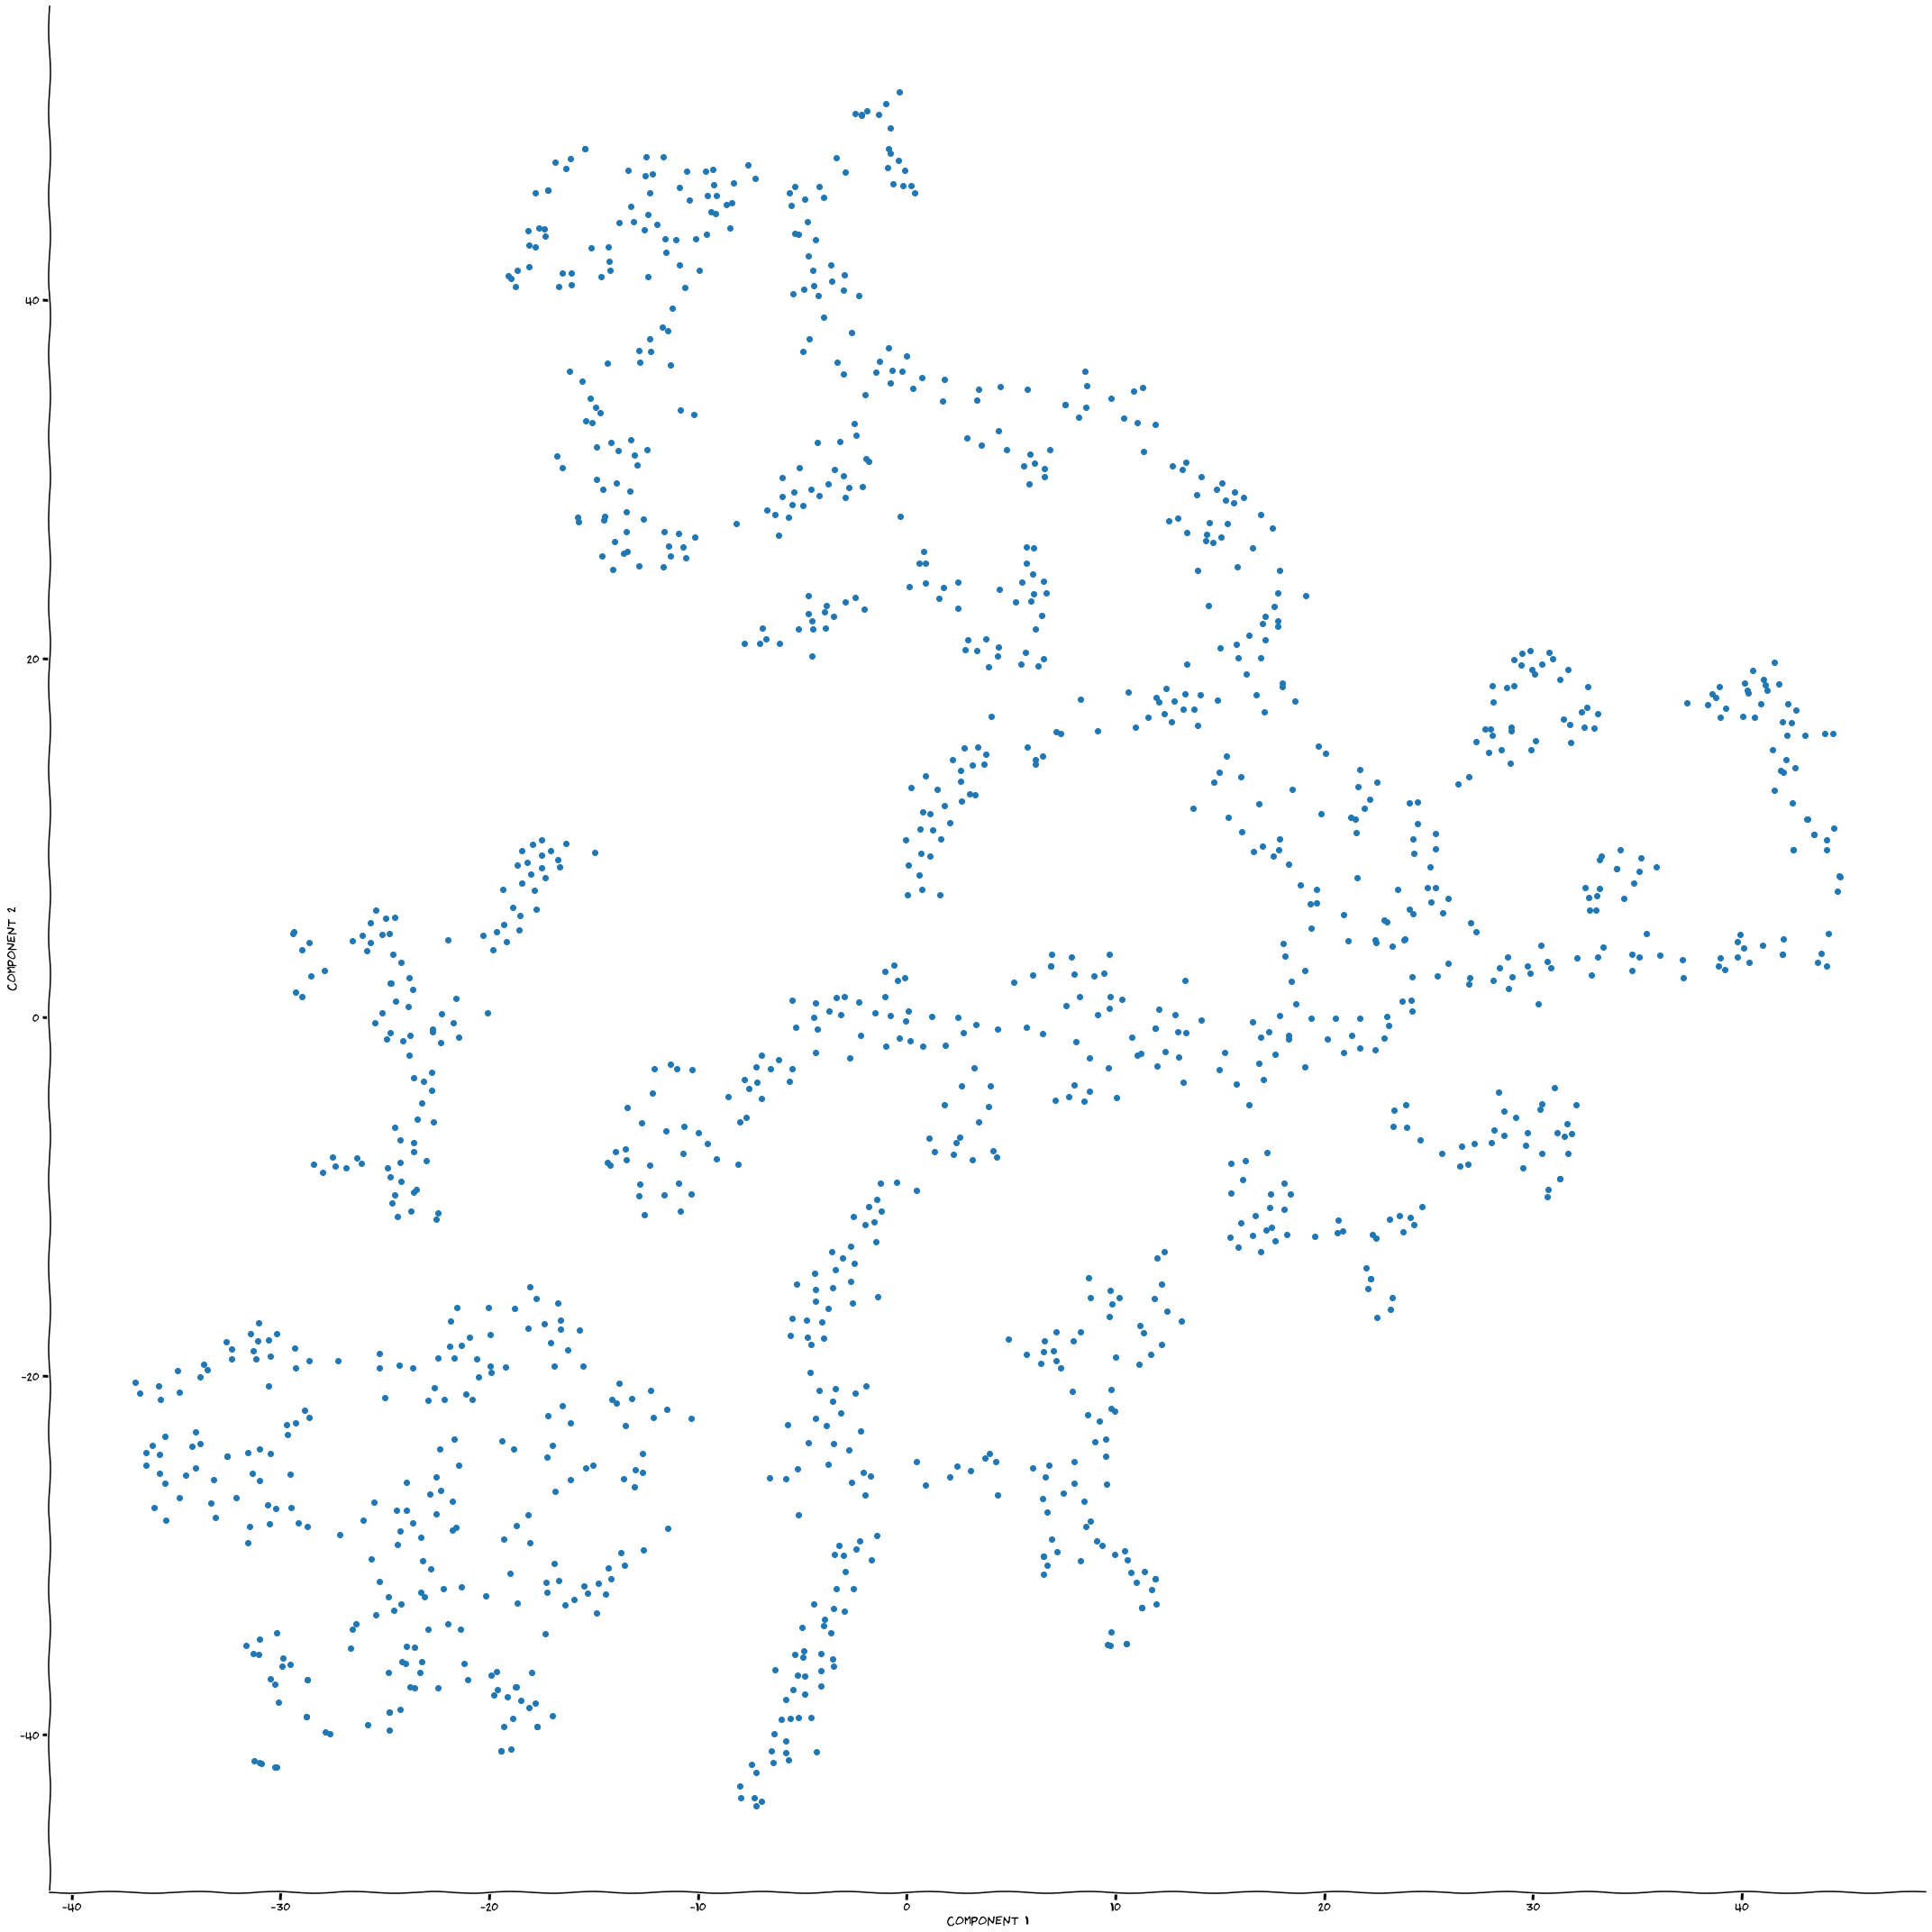

In [123]:
TSNE(n_components=2, perplexity=30, random_state=1) 
embed = tsne_model.fit_transform(transformation_results)

# Visualize the data with DBSCAN labels
with plt.xkcd():
  visualize_components(embed[:, 0], embed[:, 1])


Text(0, 0.5, 'PCA_2')

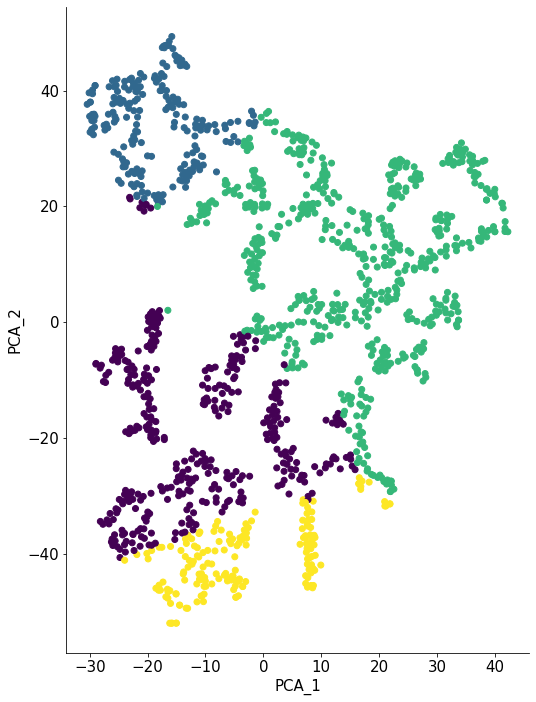

In [114]:
clusters_number = 4
kmeans = KMeans(n_clusters = clusters_number,  random_state=1).fit(transformation_results)
labels_kmeans = kmeans.labels_

plt.figure(figsize=(10,10))
plt.scatter(embed[:,0],embed[:,1], c= labels_kmeans)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('PCA_1')
plt.ylabel('PCA_2')



# 1. optimal number of clusters? 
# 2. cluster with different pca selected; leave out method
# 3. how often unit has the same label? 

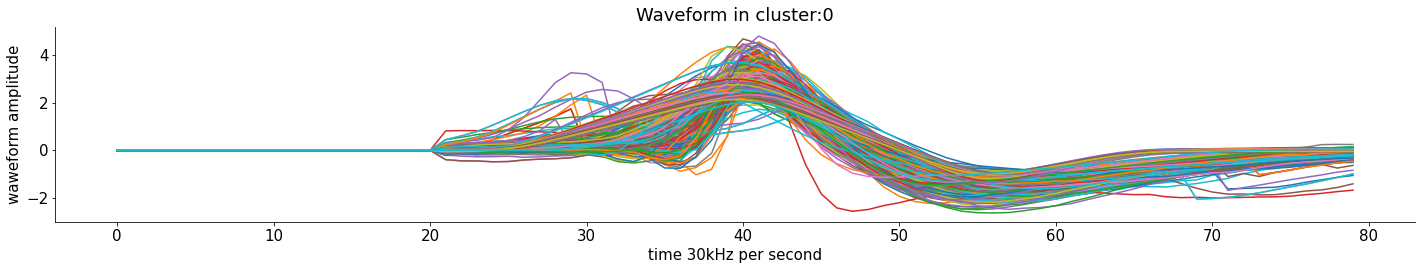

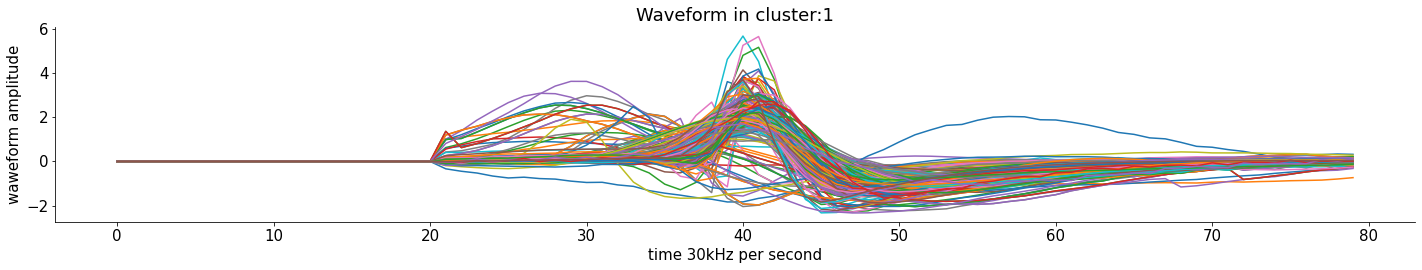

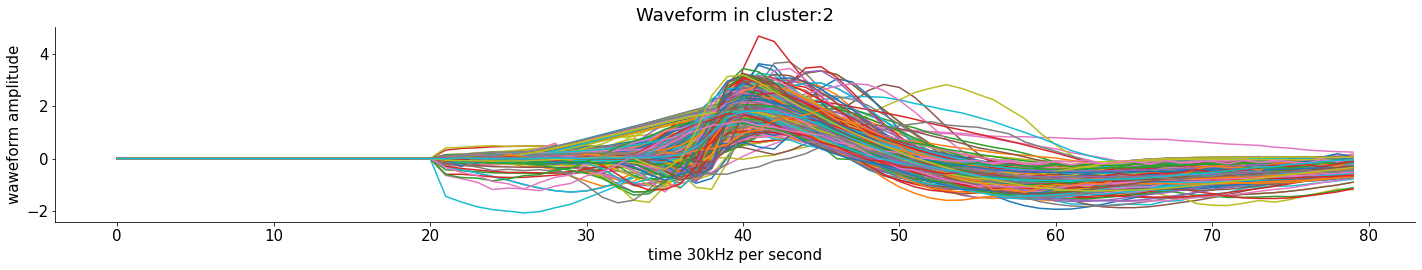

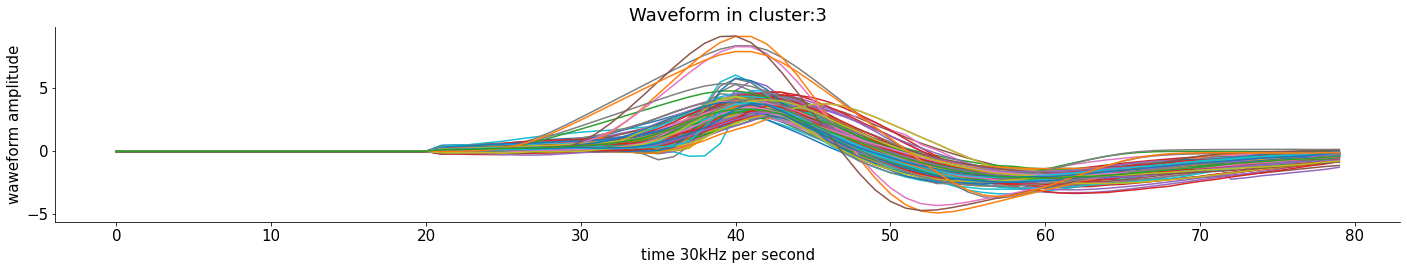

In [115]:
for i in range(0,clusters_number): 
  plt.figure()
  plt.plot(data_stack[labels_kmeans==i].T)

  plt.title(f"Waveform in cluster:{i}")
  plt.ylabel('waweform amplitude')
  plt.xlabel('time 30kHz per second')

  plt.show()
